# Métricas de Risco - *VaR* e *ES*

## Introdução

### Após completar este capítulo, você será capaz de:

- Compreender a importância das métricas de risco
- Compreender o conceito de VaR
- Calcular o VaR por metodologia histórica

### Conceitos utilizados
- Probabilidade básica
- Distribuição Normal
- Percentil
- Retorno
- PnL (*profit and loss*)

### Importância das métricas de risco💰📈
**O que são métricas de risco**   
Métricas que visam estimar **perdas potenciais** sob determinados cenários (premissas) em função de modelos de apreçamento. Em geral, são aplicáveis tanto a apenas um ativo, como em carteiras complexas e diversas, pois apresentam uma visão consolidada sobre um risco financeiro. Por este mesmo motivo, costumam utilizar ferramentas e conceitos estatísticos na mensuração.

Há métricas para estimar diversos tipos de risco financeiro, como risco de crédito, mercado, contraparte, liquidez, etc.

**Para que servem**   
São utilizadas na gestão de risco de instituições financeiras - *e na sua carteira pessoal, por que não?*   
Geralmente são vinculadas com outras ações e mitigadores, como definição de apetite de risco e limites de operação.
Também são muito utilizadas pelos órgãos reguladores do sistema financeiro para controlar a tomada de risco das instituições e garantir a saúde do mercado. Reguladores estimam o **capital** a ser alocado pela instituição financeira em função das métricas de risco.


**Exemplo em risco de mercado**

|Métrica de risco| Exigência regulatória|
|---|---|
|Value at Risk (VaR) | Capital RM (Res. 4.557 e Circ. 3.646)|
|Expected Shortfall (ES) | FRTB|
|Teste de estresse| ICAAP (Res. 4.557)|
|ΔEVE e ΔNII | IRRBB (Circ. 3.876)|



In [2]:
pip install yahoo-fin

     |████████████████████████████████| 81 kB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 3.3 MB/s  eta 0:00:01
     |████████████████████████████████| 96 kB 9.0 MB/s  eta 0:00:01
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=ae0961bb005c6bb1857dbc75c39575e5f4900e0581479b99a75944b1d967935d
  Stored in directory: /Users/michaellee/Library/Caches/pip/wheels/73/2b/cb/099980278a0c9a3e57ff1a89875ec07bfa0b6fcbebb9a8cad3
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13486 sha256=54948959f2f99c647cc99762009531763f6dd70175a86fd9590896e34ec595fa
  Stored in directory: /Users/michaellee/Library/Caches/pip/wheels/ae/e7/76/7dd44644d065268ab0e1b4fa2e802fa4bb0157717b7d6c6d92
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24581 sha256=43ec45265587a8f99bfc071257016c0c9524403cc32bc6ecdbbfc587e14fef57
  Stored in directory: /Users/michaellee/Library/Caches/pip/wheels/d6/9c/58/ee3ba368

In [1]:
# Bibliotecas
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si

### Revisão <a class="anchor" id="2"></a>
1. Retorno simples
2. PnL - Profit or Loss - Perdas ou Ganhos (resultado)

Seja $P_t$ o preço de um ativo no instante $t$.
O retorno simples é dado por:
$$ retorno_t = \frac{preço_t - preço_{t-HP}}{preço_{t-HP}} $$
ou
$$ retorno_t = \frac{preço_t}{preço_{t-HP}} -1 $$

Geralmente o retorno é expresso em porcentagem, relativamente ao período. Também é chamado de *taxa de retorno*.   
E o PnL é dado por:

$$ PnL_t = preço_t - preço_{t-HP} $$
ou
$$ PnL_t = retorno_t \cdot preço_{t-HP} $$

e representa a perda ou ganho em valor financeiro ocorrida no período decorrido da variação de preços do ativo.

In [2]:
# Captura dos dados
def read_fx_input(fx_name='^BVSP'):
#     df = pd.read_csv(path_in + fx_name + '.csv', decimal=',')
#     df = df[df.tipoBoletim == 'Fechamento'].reset_index()
#     df['date'] = df['dataHoraCotacao'].apply(lambda x: dt.datetime.strptime(x[0:10], '%Y-%m-%d').date())
#     df['price'] = (df.cotacaoCompra + df.cotacaoVenda)/2 # mid
#     return df[['date', 'price']].set_index('date')
    df = si.get_data('^BVSP', start_date = '01/01/2010', index_as_date = True, interval = '1d')
    df = df.loc[:,['adjclose']]
    df.columns = ['price']
    return df

df_inputs = read_fx_input()

bid = oferta de venda
ask = oferta de compra
mid = preço médio

In [ ]:
# df_inputs = read_fx_input('USD', '')
# df_inputs.head()

Temos uma base de preços históricos. 
Calculemos os retornos:

In [3]:
def calc_ret_pnl(df, hp): # df = df_usd
    df['return'] = (df['price']/df['price'].shift(hp) - 1) # Retorno
    df['PnL'] = df['price'] - df['price'].shift(hp) # Realizado
    # df['logReturn'] = df.apply(lambda x: np.log(x['return']), axis=1) # log retorno
    return df

In [4]:
df_metrics = calc_ret_pnl(df_inputs, hp=1)
df_metrics.head()

,price,return,PnL
2010-01-04,70045.0,NaN,NaN
2010-01-05,70240.0,0.002784,195.0
2010-01-06,70729.0,0.006962,489.0
2010-01-07,70451.0,-0.003930,-278.0
2010-01-08,70263.0,-0.002669,-188.0


### 3. Definições <a class="anchor" id="3"></a>
1. *VaR - Value at Risk*
2. *ES - Expected shortfall*
3. Parâmetros comuns

#### VaR
Conceito:
- Pior perda esperada sob condições normais de mercado, ao longo de determinado intervalo de tempo ($HP$) e dentro de determinado nível de confiança ($1−\alpha$).

Definição:   
Seja $x(t)$ a série temporal de resultados (PnL), então:

$$ VaR_{1-\alpha}^{HP}(t) = \inf \{y \in \mathbb{R}: Pr(x(t)) > y = 1 - \alpha \} $$

Exemplo:   
Se um portfólio possui um VaR para $HP=10$ dias e nível de confiança 95\% no valor de R\$ 1 milhão, significa que:
- Há uma probabilidade de $\alpha = 5\%$ que o portfólio perca mais de R$ 1 milhão num intervalo de 10 dias, caso o portfólio permaneça o mesmo neste período. 

<div>
    <img src="Imagens/09_01_var_conceito.png" style="width: 600px;"/>
</div>

#### *Expected Shortfall*
Conceito:
- Valor esperado (média) da perda condicional ao estouro do VaR, ao longo de determinado intervalo de tempo ($𝐻𝑃$) e dentro de determinado nível de confiança ($1−\alpha$).

Definição:
$$ ES_{1-\alpha}^{HP}(t) = \mathbb{E}[x(t) | x(t) < VaR_{1-\alpha}^{HP}(t)] $$

Exemplo:   
Se o ES é de R\$ 10 milhões, significa que:
- Caso ocorra uma perda pior que o VaR (estouro), o valor esperado dessa perda é de R\$ 10 milhões.

<div>
    <img src="Imagens/09_02_metricas_NTN-B_99.0.png" style="width: 800px;"/>
</div>

#### Parâmetros Comuns
A definição dos parâmetros pode vir por exigência regulatória ou por decisão interna da instituição financeira, de acordo com seus apetites de risco ou uso dos modelos. A seguir, temos os valores mais comuns para o *holding period* e para o nível de confiança.

$HP$: 
- 1 dia (usado em cálculo de limites)
- 10 dias (usado para cálculo de capital)
- 30 dias (usado em métricas de liquidez)

Nível de confiança ($ 1 - \alpha $):
- 99%
- 97,5%
- 95%

O nível de confiança é unilateral, pois sob uma visão de riscos, a preocupação é apenas sobre as perdas.

### Métodos de cálculo<a class="anchor" id="4"></a>
1. **Paramétrico**   
Premissa: distribuições teóricas com parâmetros conhecidos   
Custo processamento: baixo   
Custo base de dados: baixo   
Maior fragilidade: depende diretamente da amostra utilizada na calibração dos parâmetros e da adequação das distribuições utilizadas

2. **Histórico**   
Premissa: informações passadas representam bem a distribuição   
Custo processamento: baixo   
Custo base de dados: alto   
Maior fragilidade: depende diretamente da amostra utilizada

3. **Simulação por Monte Carlo**   
Premissa: adequação dos modelos de projeção   
Custo processamento: alto   
Custo base de dados: alto   
Maior fragilidade: risco de modelo

#### Histórico

O VaR histórico é facilmente computado, porém exige uma maior quantidade de dados armazenados. Sua vantagem é que não há assunção de distribuição teórica sobre os retornos, pois os percentis são calculados diretamente a partir da amostra de realizações já ocorridas. Isto acaba sendo também uma desvantagem, pois o modelo é baseado apenas em informações passadas, falhando em predizer possíveis movimentações que não ocorreram no período histórico utilizado na mensuração.   

Na simulação histórica, primeiramente define-se a quantidade $n$ de cenários que será utilizada como tamanho da amostra para cálculo dos percentis. Com isto, obtemos uma série com $n$ retornos já realizados. Em geral, utilizam-se os retornos mais recentes e, portanto:

$$ sRet_t = \{retorno(\tau)\}_{t-n}^{t} $$

Estes retornos são aplicados ao valor financeiro atual para gerar uma série de possíveis cenários de perdas e ganhos (PnLs):

$$ sPnL_t = MtM_t \cdot sRet_t = \{MtM_t \cdot retorno(\tau)\}_{t-n}^{t} $$

𝑃ara obter o VaR, calcula-se o percentil $\alpha$ desta série:

$$ VaR_{1-\alpha}(t) = Percentil[sPnL_t, \alpha] $$

Na prática, ordenam-se os valores de PnL simulados e busca-se o $\alpha$-ésimo pior valor da série.   
Para obter o ES, é calculada a média de todos os valores da série abaixo do VaR, ou seja, das perdas piores que o valor do VaR:

$$ ES_{1 - \alpha}(t) = Média[x | x < VaR_{1-\alpha}(t)], x \in sPnL_t $$

É comum utilizar $n = 1000$ dias mais recentes para cálculo histórico, que representam aproximadamente 4 anos de dados diários. 

#### Exemplo prático: Método histórico simples com um único fator de risco
Calcular o VaR histórico de 1 dia com 99% de confiança para USD Spot

Cálculo da série de PnLs: $ sPnL_t $   
Fazemos o corte do período utilizado como amostra. Em nosso exemplo, usaremos os últimos 1000 PnLs:

In [5]:
amostra_PnL = df_metrics.PnL.iloc[len(df_metrics)-1000:len(df_metrics)]
amostra_PnL

2018-01-30    -216.0000
2018-01-31     431.0000
2018-02-01     582.0000
2018-02-02   -1454.0000
2018-02-05   -2180.0000
                ...    
2022-02-08     238.0000
2022-02-09     227.0000
2022-02-10     898.0000
2022-02-11     136.0000
2022-02-14     404.1875
Name: PnL, Length: 1000, dtype: float64

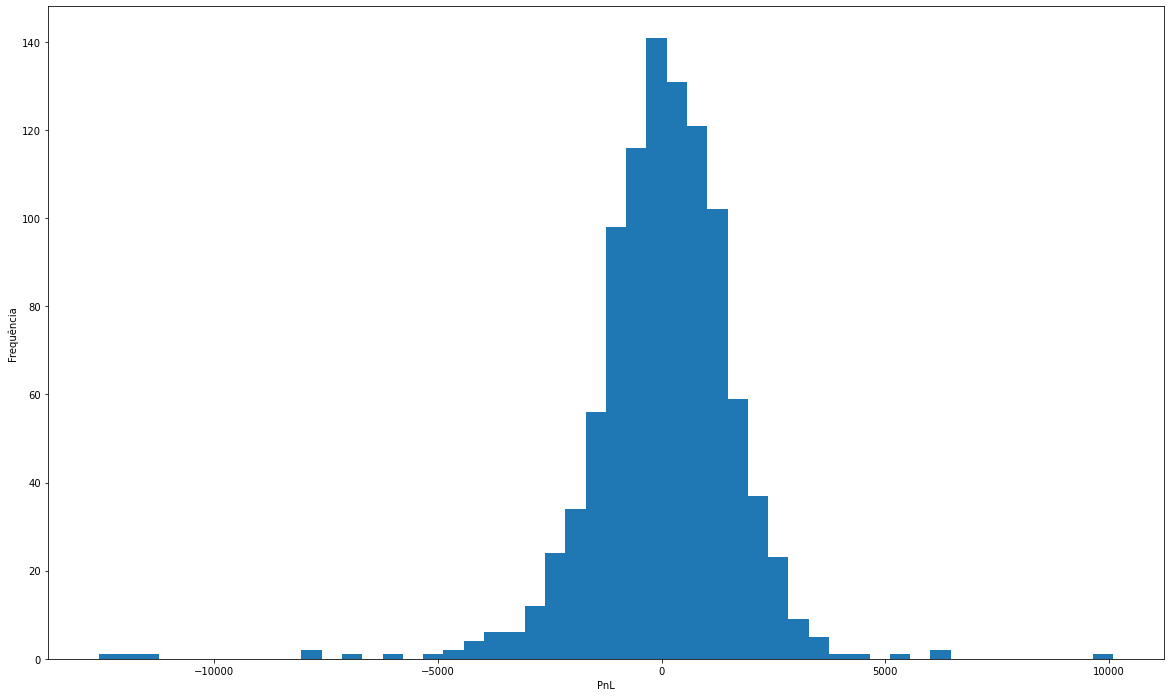

In [6]:
# Histograma da amostra de 1000 dias
plt.figure(figsize=(20,12))
plt.hist(amostra_PnL, density=False, bins=50)
plt.ylabel('Frequência')
plt.xlabel('PnL');

Text(0.5, 1.0, 'Histograma')

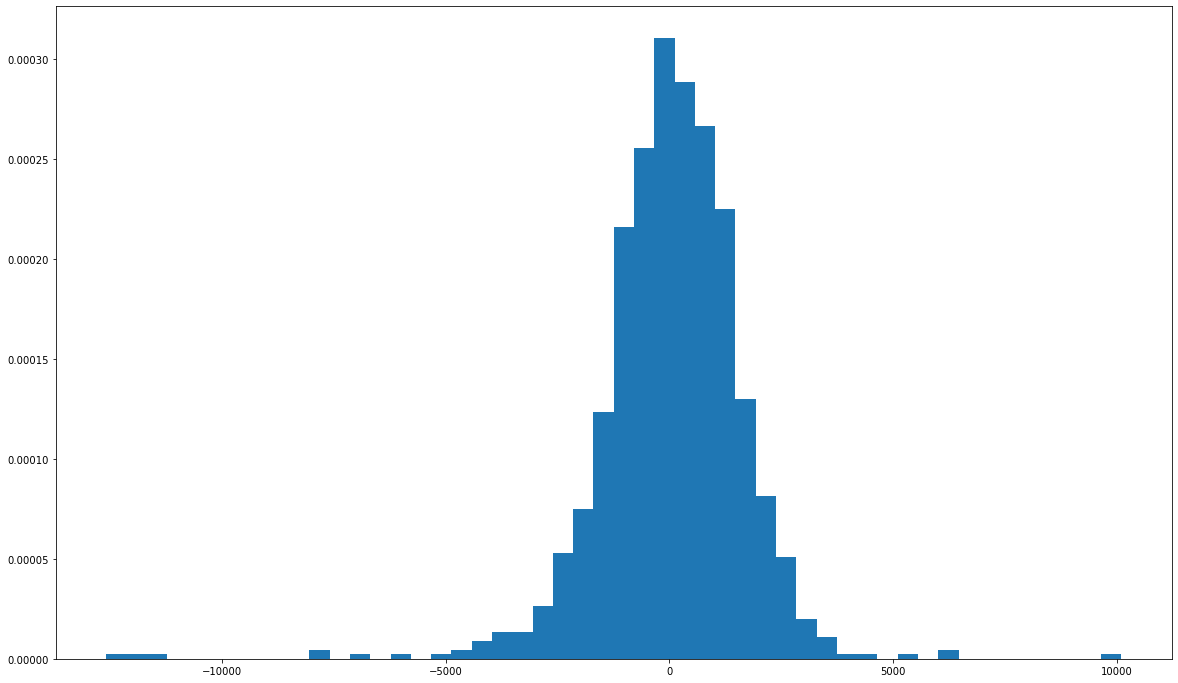

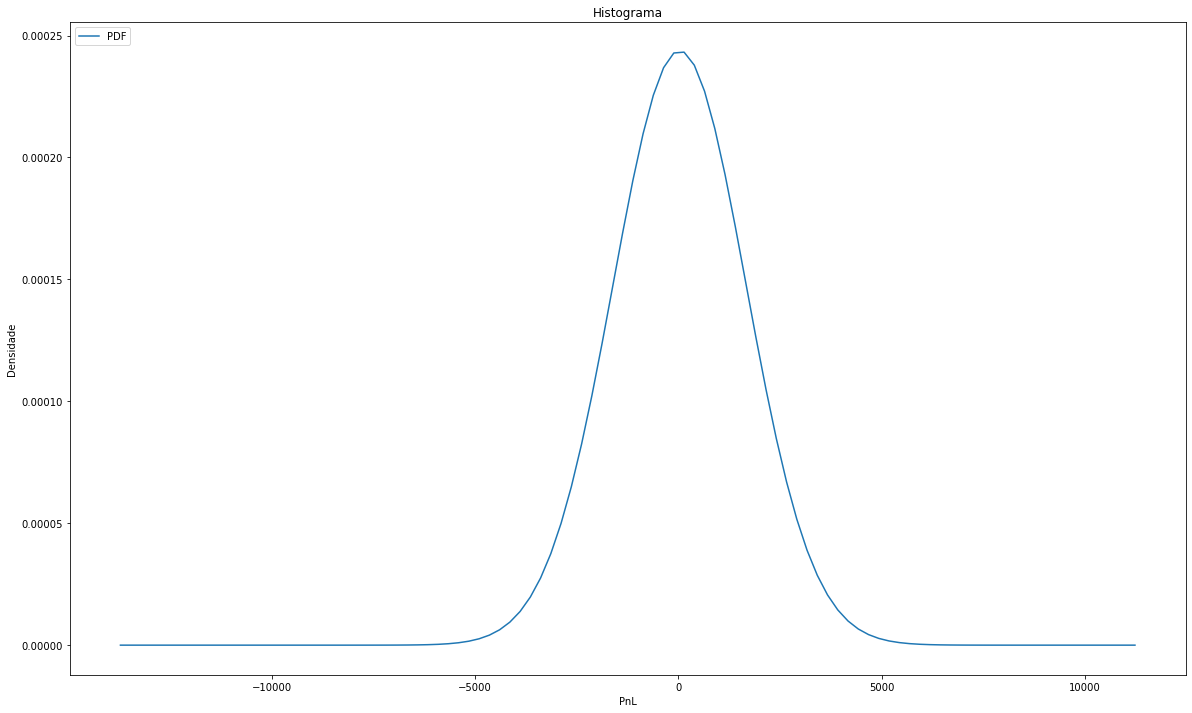

In [7]:
import scipy.stats as st
bins = 50
plt.figure(figsize=(20,12))
plt.hist(amostra_PnL, density=True, bins=bins, label="Dados")
xmin, xmax = plt.xlim()
mu, sigma = st.norm.fit(amostra_PnL)
x = np.linspace(xmin, xmax, 100)
curve = st.norm.pdf(x, mu, sigma)
plt.figure(figsize=(20,12))
plt.plot(x, curve, label="PDF")
plt.legend(loc="upper left")
plt.ylabel('Densidade')
plt.xlabel('PnL')
plt.title("Histograma")

Para obter o VaR, basta buscar o percentil desejado $\alpha$:

In [36]:
alpha = 0.01
var = amostra_PnL.quantile(alpha)
print("VaR 99% = R$ " + "{:.2f}".format(- var))

VaR 99% = R$ 7049.79


Para obter o ES, basta calcular a média dos valores abaixo do VaR:

In [9]:
amostra_es = amostra_PnL[amostra_PnL <= var]
amostra_es

2020-02-26    -7963.0
2020-03-05    -4991.0
2020-03-09   -11930.0
2020-03-11    -7043.0
2020-03-12   -12588.0
2020-03-16   -11510.0
2020-03-18    -7722.0
2021-02-22    -6080.0
2021-03-08    -4590.0
2021-09-08    -4456.0
Name: PnL, dtype: float64

In [35]:
es = amostra_PnL[amostra_PnL <= var].mean()
print("ES 99% = R$ " + "{:.2f}".format(-es))

ES 99% = R$ 5316.80


### 5. Exercícios<a class="anchor" id="5"></a>

1. É possível o ES apresentar um valor menor (em módulo) que o VaR:   
a) sob o mesmo nível de confiança?   
b) sob um nível de confiança maior (ex: ES 95% e VaR 99%)?   
c) sob um nível de confiança menor (ex: ES 99% e VaR 95%)?

Resposta aqui

a) Não,visto que o ES é calculada através da média de todos os valores da série **abaixo** do VaR, ou seja, das perdas piores que o valor do VaR.

b) Sim. Nesse caso, visto que o ES possui um maior nível de confiança, o VaR tende a ter uma valor menor(em módulo) do que o VaR.

c) Não. Nesse caso, visto que o VaR possui um maior nível de confiança, o ES tende a ter uma valor ainda maior(em módulo) em relação ao VaR, do que no caso da letra a.

2. Calcule o VaR histórico com nível de confiança de 95% e HP=1, para a última data disponível de USD Spot (30/04/2021), utilizando uma amostra de 500 dias.

In [62]:
# Resposta aqui 

# Importando o CSV

df_usd = pd.read_csv('USD.csv')

df_usd.head()

,paridadeCompra,paridadeVenda,cotacaoCompra,cotacaoVenda,dataHoraCotacao,tipoBoletim
0,1,1,"1,725","1,735",2010-01-04 09:23:00.0,Abertura
1,1,1,"1,728","1,73",2010-01-04 09:30:00.0,Intermediário
2,1,1,"1,727","1,729",2010-01-04 10:00:00.0,Intermediário
3,1,1,"1,728","1,73",2010-01-04 10:30:00.0,Intermediário
4,1,1,"1,728","1,73",2010-01-04 11:00:00.0,Intermediário


In [63]:
df_usd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18604 entries, 0 to 18603
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   paridadeCompra   18604 non-null  int64 
 1   paridadeVenda    18604 non-null  int64 
 2   cotacaoCompra    18604 non-null  object
 3   cotacaoVenda     18604 non-null  object
 4   dataHoraCotacao  18604 non-null  object
 5   tipoBoletim      18604 non-null  object
dtypes: int64(2), object(4)
memory usage: 872.2+ KB


In [64]:
# Convertendo os Valores das Colunas cotacaoCompra e cotacaoVenda para Float

df_usd['cotacaoCompra'] = df_usd['cotacaoCompra'].apply(lambda x: x.replace(',','.')).astype(float)
df_usd['cotacaoVenda'] = df_usd['cotacaoVenda'].apply(lambda x: x.replace(',','.')).astype(float)
df_usd.head()

,paridadeCompra,paridadeVenda,cotacaoCompra,cotacaoVenda,dataHoraCotacao,tipoBoletim
0,1,1,1.725,1.735,2010-01-04 09:23:00.0,Abertura
1,1,1,1.728,1.730,2010-01-04 09:30:00.0,Intermediário
2,1,1,1.727,1.729,2010-01-04 10:00:00.0,Intermediário
3,1,1,1.728,1.730,2010-01-04 10:30:00.0,Intermediário
4,1,1,1.728,1.730,2010-01-04 11:00:00.0,Intermediário


In [122]:
# Gerando as colunas retornoCompra, retornoVenda, PnLCompra, PnLVenda
# Multipliquei por 100 para que os resultados possam resultar em valores que não muito próximos de zero

df = df_usd
hp = 1
df['retornoCompra'] = (df['cotacaoCompra']/df['cotacaoCompra'].shift(hp) - 1)*100 # Retorno Compra
df['retornoVenda'] = (df['cotacaoVenda']/df['cotacaoVenda'].shift(hp) - 1)*100 # Retorno Venda
df['PnLCompra'] = df['retornoCompra'] - df['retornoCompra'].shift(hp - 1)*100 # Realizado Compra
df['PnLVenda'] = df['retornoVenda'] - df['retornoVenda'].shift(hp - 1)*100 # Realizado Venda

df = df.drop(['paridadeCompra', 'paridadeVenda', 'tipoBoletim'],axis=1)
df.sample(10).head()

,cotacaoCompra,cotacaoVenda,dataHoraCotacao,retornoCompra,retornoVenda,PnLCompra,PnLVenda
17836,5.2603,5.2609,2020-09-16 10:09:18.047,-0.225712,-0.225687,22.345510,22.342968
15299,4.1838,4.1844,2018-09-04 11:09:19.433,0.446557,0.446493,-44.209162,-44.202794
1362,1.7270,1.7290,2010-04-30 13:00:23.824,-0.115674,-0.115540,11.451706,11.438475
3997,1.6970,1.6990,2010-12-14 11:30:19.567,0.117994,0.117855,-11.681416,-11.667649
10448,2.4763,2.4770,2014-10-16 13:10:18.164,0.064654,0.068679,-6.400776,-6.799176


### Cálculo do VaR

#### PNL Compra

In [123]:
amostra_PnLC2 = df.PnLCompra.iloc[len(df)-500:len(df)]
amostra_PnLC2

18104     4.734577
18105    -2.084211
18106    32.961482
18107    63.102118
18108    72.497343
           ...    
18599    10.886015
18600   -66.311547
18601   -57.246645
18602    -5.655266
18603    49.045102
Name: PnLCompra, Length: 500, dtype: float64

In [124]:
alpha = 0.05
var = amostra_PnLC2.quantile(alpha)
print("VaR 95% = R$ " + "{:.2f}".format(- var))

VaR 95% = R$ 88.75


#### PNL Venda

In [128]:
amostra_PnLV2 = df.PnLVenda.iloc[len(df)-500:len(df)]
amostra_PnLV2

18104     4.734033
18105    -2.083971
18106    32.957698
18107    63.094850
18108    72.488940
           ...    
18599    10.884797
18600   -66.304125
18601   -57.240280
18602    -5.654641
18603    49.039683
Name: PnLVenda, Length: 500, dtype: float64

In [129]:
alpha = 0.05
var = amostra_PnLV2.quantile(alpha)
print("VaR 95% = R$ " + "{:.2f}".format(- var))

VaR 95% = R$ 88.74


3. Calcule o ES histórico com nível de confiança de 97,5% e HP=1, para a última data disponível de USD Spot (30/04/2021), utilizando uma amostra de 1000 dias.

In [116]:
# Resposta aqui

#### PNL Compra

In [130]:
amostra_PnLC2 = df.PnLCompra.iloc[len(df)-1000:len(df)]
amostra_PnLC2

17604     5.188582
17605    -6.859936
17606   -27.976569
17607     9.791919
17608    25.891056
           ...    
18599    10.886015
18600   -66.311547
18601   -57.246645
18602    -5.655266
18603    49.045102
Name: PnLCompra, Length: 1000, dtype: float64

In [131]:
alpha = 0.25
var = amostra_PnLC2.quantile(alpha)
print("VaR 97,5% = R$ " + "{:.2f}".format(- var))

VaR 97,5% = R$ 28.47


#### PNL Venda

In [132]:
amostra_PnLV2 = df.PnLVenda.iloc[len(df)-1000:len(df)]
amostra_PnLV2

17604     5.187999
17605    -6.859165
17606   -27.973428
17607     9.790823
17608    25.888154
           ...    
18599    10.884797
18600   -66.304125
18601   -57.240280
18602    -5.654641
18603    49.039683
Name: PnLVenda, Length: 1000, dtype: float64

In [133]:
alpha = 0.25
var = amostra_PnLV2.quantile(alpha)
print("VaR 97,5% = R$ " + "{:.2f}".format(- var))

VaR 97,5% = R$ 28.72


4. Calcule a série temporal de VaR 99% e 97,5%, com HP=1, utilizando uma amostra de 1000 dias para todas as datas possíveis.   
Dica: Há 2844 dias com preços na base, removendo HP=1 para cálculo do primeiro retorno e 1000 para amostra do 1º VaR, teremos como resultado uma série de VaRs de tamanho 1843.

In [9]:
# Resposta aqui

In [ ]:
# Gerando as colunas retornoCompra, retornoVenda, PnLCompra, PnLVenda
# Multipliquei por 100 para que os resultados possam resultar em valores que não muito próximos de zero

df = df_usd
hp = 1
df['retornoCompra'] = (df['cotacaoCompra']/df['cotacaoCompra'].shift(hp) - 1)*100 # Retorno Compra
df['retornoVenda'] = (df['cotacaoVenda']/df['cotacaoVenda'].shift(hp) - 1)*100 # Retorno Venda
df['PnLCompra'] = df['retornoCompra'] - df['retornoCompra'].shift(hp - 1)*100 # Realizado Compra
df['PnLVenda'] = df['retornoVenda'] - df['retornoVenda'].shift(hp - 1)*100 # Realizado Venda

df = df.drop(['paridadeCompra', 'paridadeVenda', 'tipoBoletim'],axis=1)
df.sample(10).head()

### Referências bibliográficas<a class="anchor" id="6"></a>

Didáticos:   
- [Pedro A. Moretin, Econometria financeira: um curso em séries temporais financeiras](https://books.google.com.br/books/about/Econometria_financeira.html?id=I3i5DwAAQBAJ&source=kp_book_description&redir_esc=y)
- [Philippe Jorion, Value at Risk](https://merage.uci.edu/~jorion/VAR/)

Normas de reguladores:
- [BCB, 2017, Resolução 4.557](https://www.bcb.gov.br/pre/normativos/busca/downloadNormativo.asp?arquivo=/Lists/Normativos/Attachments/50344/Res_4557_v2_L.pdf)
- [BCB, 2013, Circular 3.646](https://www.bcb.gov.br/htms/Normativ/CIRCULAR3646.pdf)
- [BCB, 2018, Circular 3.876](https://www.bcb.gov.br/estabilidadefinanceira/exibenormativo?tipo=Circular&numero=3876)
- [BIS, 2019, Minimum capital requirements for market risk (FRTB)](https://www.bis.org/bcbs/publ/d457.pdf)

# Extra - Exposição a Fatores de Risco

Após completar este capítulo, você será capaz de:

- Compreender o que são fatores de risco
- Compreender o que é exposição a risco
- Calcular exposição a risco

## Fator de risco

Um fator de risco de um produto ou portfólio é uma fonte de risco e retorno. É uma variável de mercado que apresenta alguma incerteza sobre seus valores futuros.

**Exemplo**

Suponha que você possui um contrato a termo de dólar com notional de R\\$1.000,00 e vencimento em 3 meses. Para estimarmos o valor de mercado (MtM) deste contrato, precisamos projetar o valor futuro do dólar e descontá-lo a valor presente.

$$ MtM = Notional \cdot Spot_{USD} \cdot \frac{Fator_{CupomUSD}}{Fator_{Pré}} $$

O seu contrato a termo não é uma variável de mercado, comum a todos os participantes, portanto, não poderia ser utilizado como fator de risco. Contudo, podemos identificar, através da equação de preço acima, seus fatores de risco.

- Notional: é uma variável cadastral e fixa, definida em contrato. Portanto, não é uma fonte de risco;
- $Spot_{USD}$: é o preço a vista da moeda USD; é uma variável de mercado e possui incerteza sobre seus valores futuros;
- $Fator_{CupomUSD}$: é o fator que representa o diferencial entre as taxas básicas de juros entre o Brasil e os EUA. Também apresenta incerteza e pode ser calculada a partir do mercado;
- $Fator_{Pré}$: é o fator de juros da taxa livre de risco brasileira e apresenta incerteza sobre seus valores futuros.

Portanto, podemos identificar os seguintes fatores de risco para um contrato a termo de USD: 

$$ Spot_{USD}, Fator_{CupomUSD} e Fator_{Pré} $$

## Exposição
Exposição é a quantidade de valor financeiro que pode ser perdida devido aos riscos associados a um determinado fator de risco.

**Exemplo**

Suponha ainda que as variáveis pssuam os seguites valores hoje:

- $Spot_{USD}$ = 5,10;
- $Fator_{CupomUSD}$: 1,01;
- $Fator_{Pré}$: 1,06.


Logo, seu contrato a termo de USD vale: 

$$ MtM = 1000 \cdot 5,10 \cdot \frac{1,01}{1,06} $$
$$ MtM = R\$4.859,43 $$

Então, este é o valor que você está exposto em cada um dos fatores de risco identificados acima.

Agora, imagine que o valor do dólar a vista caia 20\% para R\$4,08, enquanto os fatores de juros seguem os mesmos. Qual seria o impacto no contrato?

$$ MtM_{simulado} = 1000 \cdot 4,08 \cdot \frac{1,01}{1,06} $$
$$ MtM_{simulado} = R\$3.887,55 $$

O valor do contrato a termo cairia 4.859,43 - 3.887,55 = 971,88.
Veja que este valor equivale a uma variação relativa de: 971,88/4.859,43 = 20\%. Ou seja, a mesma variação observada no valor do dólar a vista.

Desta forma, podemos estimar perdas potenciais num contrato (ou num portfólio) a partir das variações dos fatores de risco. Neste caso, ao invés de recalcular o preço simulado da carteira, poderíamos aplicar a variação projetada do dólar de 20\% diretamente sobre a exposição em carteira:

$$ Perda Potencial = 20\% \cdot 4.859,43 = R\$ 971,88 $$

Esta relação ocorre neste tipo de contrato, pois o preço deste derivativo é **linear** em função do spot. Esta relação não ocorre para opções e outros derivativos exóticos que não apresentem relação linear (são chamados de derivativos não lineares). Para estimar perdas potenciais de portfólios com opções, as exposições a fatores de risco são mensuradas pelas **gregas**.

## Gregas

Vimos anteriormente que o preço de uma opção depende de uma série de parâmetros. Uma pergunta muito comum (principalmente para gestores de risco) é: o que acontece com o valor da minha opção (ou da minha carteira de opções) quando há variações nesses parâmetros? Ou ainda: qual é risco a que um portfólio está submetido em razão das variações de mercado?

Uma parte da resposta a essa pergunta está relacionada com uma série de quantidades, quase sempre representadas por letras gregas, que medem a sensibilidade da opção com relação a seus parâmetros mais comuns. Essas quantidades são chamadas de **gregas** da opção.

As gregas são obtidas pelo cálculo das derivadas parciais do preço da opção com relação a um (ou mais) de seus parâmetros. No modelo B&S, que possui fórmula fechada e diferenciável, há solução analítica para o cálculo das gregas. Em outros casos, muitas vezes é preciso recorrer a técnicas de derivação numérica para encontar seus valores. 

![Tabela gregas](Imagens/06_08_Tabela_gregas.png)

Tabela de equações das gregas no modelo de Black-Scholes (Fonte: Hull, 2016).
![Tabela gregas](Imagens/06_09_Tabela_gregas_BS.png)

Vejamos na figura abaixo a representação gráfica do conceito do Delta. Ele representa o coeficiente angular do preço da opção em função do preço spot do ativo objeto. Em outras palavras, quanto a variação do spot vai afetar o preço da opção. Na figura, o Delta possui um valor de 0,6, significa que uma variação no spot impacta em 60% o preço da opção.

![Delta slope](Imagens/08_01_Delta_Slope.png)

**Exemplo**

Suponha que um investidor vendeu 2.000 opções de compra (*calls*) de uma ação que vale R\\$10,00 e gostaria de neutralizar sua exposição à ação. Suponha ainda que o preço de cada opção é R\\$1,00 e o Delta dessas opções hoje vale 0,5. 

Neste caso, para neutralizar o risco, bastaria ele comprar: $2.000 \cdot 0,5 = 1.000$ ações. Veja que não precisamos utilizar o preço da opção, nem o preço da ação para identificar a quantidade de ações a ser comprada. Utilizamos apenas o Delta e a quantidade de opções.

Desta forma, se a ação desvalorizar R\\$0,50, ele terá uma desvalorização total nas ações de R\\$500,00, mas por outro lado, terá um ganho nas calls, que terão desvalorizado R\\$0,25. Como o investidor vendeu 2.000 ações, essa desvalorização gerará um lucro de R\$500,00. Portanto, o resultado teve um *hedge* com sucesso e o resultado foi neutralizado. Esta técnica é conhecida com ***delta hedging***.

Esta estratégia, apesar de muito utilizada no mercado, não é perfeita, pois não considera outros fatores de risco como a volatilidade, o prazo, entre outros. Além disso, o Delta também varia ao longo do tempo, de forma que o portfólio de hedge deve ser rebalanceado e isto pode gerar custos transacionais que superem o resultado ganho.